In [45]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.branch_definer as branch_definer
import model.util as model_util
import model.image_unet as image_unet
import model.generate as generate
from plot.plot import plot_mnist_digits
from analysis.fid import compute_fid
import torch
import torchvision
import numpy as np
import os
import json
import scipy.cluster.hierarchy
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [35]:
out_dir = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/config/classes_branch_points/mnist/branch_point_discovery_variants/"

model_base = "/gstore/scratch/u/tsenga5/branched_diffusion/models/trained_models/mnist_continuous_branch_variation/"

cache_dir = "/gstore/home/tsenga5/branched_diffusion/results/mnist_branch_variation/"

In [11]:
num_trials = 10

### Create the data loader

In [4]:
samples_per_digit = 100
dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

classes = torch.unique(dataset.targets).cpu().numpy()
input_shape = (1, 28, 28)

In [5]:
# Create the diffuser
diffuser = sdes.VariancePreservingSDE(0.1, 20, input_shape)
t_limit = 1

### Compute branch definitions

In [6]:
# all_branch_defs = []

# for i in range(num_trials):
#     print(i)
#     # Sample digits
#     digits_by_class = {}
#     for c in classes:
#         mask = dataset.targets == c
#         digits = (dataset.data[mask] / 256 * 2) - 1
#         sample_inds = torch.tensor(np.random.choice(len(digits), size=samples_per_digit, replace=False))
#         digits_by_class[c] = digits[sample_inds][:, None].to(DEVICE)

#     # Run forward diffusion
#     times = np.linspace(0, t_limit, 1000)
#     diffused_digits_by_class = branch_definer.run_forward_diffusion(
#         digits_by_class, diffuser, times
#     )
    
#     # Compute similarity matrices
#     sim_matrix, sim_matrix_classes = branch_definer.compute_time_similarities(diffused_digits_by_class, times)
    
#     # Compute branch points
#     branch_points = branch_definer.compute_branch_points(sim_matrix, times, sim_matrix_classes, epsilon=0.005)
#     branch_defs = branch_definer.branch_points_to_branch_defs(branch_points, t_limit)
#     all_branch_defs.append(branch_defs)
    
#     # Write to file
#     branch_defs = [
#         ([int(x) for x in trip[0]], float(trip[1]), float(trip[2])) for trip in branch_defs
#     ]
#     s = json.dumps(
#         {"classes": sorted(list(set(sum((list(trip[0]) for trip in branch_defs), [])))), "branches": branch_defs},
#         indent=4
#     )
#     out_path = "trial_%d.json" % i
#     with open(os.path.join(out_dir, out_path), "w") as f:
#         f.write(s)

### Visualize variation in branch definitions

In [7]:
def import_classes_branch_points(json_path):
    with open(json_path, "r") as f:
        d = json.load(f)
        return d["classes"], \
            [(tuple(trip[0]), trip[1], trip[2]) for trip in d["branches"]]

all_branch_defs = []
for i in range(num_trials):
    json_path = os.path.join(out_dir, "trial_%d.json" % i)
    all_branch_defs.append(import_classes_branch_points(json_path)[1])

In [8]:
def branch_defs_to_linkage_matrix(branch_defs, add_outgroup=True):
    """
    Converts a list of branch-definition triplets into a SciPy
    hierarchy linkage matrix.
    Returns a linkage matrix, and a dictionary mapping cluster ID
    in the linkage matrix to the actual class.
    If `add_outgroup` is True, then also add a dummy outgroup with
    class name "$".
    """
    classes = max(branch_defs, key=(lambda t: len(t[0])))[0]
    max_time = max(branch[2] for branch in branch_defs)
    
    if add_outgroup:
        epsilon = 1e-6
        branch_defs = branch_defs + [
            (("$",), 0, max_time),
            (classes + ("$",), max_time, max_time)
        ]
        classes = classes + ("$",)
    
    branch_defs = sorted(branch_defs, key=(lambda t: t[1]))

    linkage = []
    clusters = {}  # Map cluster ID to pair: (cluster elements, endpoint)
    cluster_id_to_leaf = {}  # Map cluster ID to actual leaf element

    for i, (elems, start, end) in enumerate(branch_defs):
        if i < len(classes):
            assert len(elems) == 1
            assert start == 0
            clusters[i] = (elems, end)
            cluster_id_to_leaf[i] = elems[0]
        elif i == len(branch_defs) - 1:
            assert len(elems) == len(classes)
            assert end == max_time
            assert len(clusters) == 2
            cluster_ids = list(clusters.keys())
            linkage.append([cluster_ids[0], cluster_ids[1], start, len(elems)])
        else:
            # Find the two clusters whose endpoint are this startpoint, and whose
            # elements add up to this cluster
            matches = [
                (cluster_id, tup) for cluster_id, tup in clusters.items()
                if tup[1] == start and set(tup[0]) < set(elems)
            ]
            assert len(matches) == 2 and set(matches[0][1][0] + matches[1][1][0]) == set(elems)
            linkage.append([matches[0][0], matches[1][0], start, len(elems)])
            clusters[i] = (elems, end)
            # Delete clusters that were just joined (makes subsequent searches faster)
            del clusters[matches[0][0]]
            del clusters[matches[1][0]]
            
    return linkage, cluster_id_to_leaf

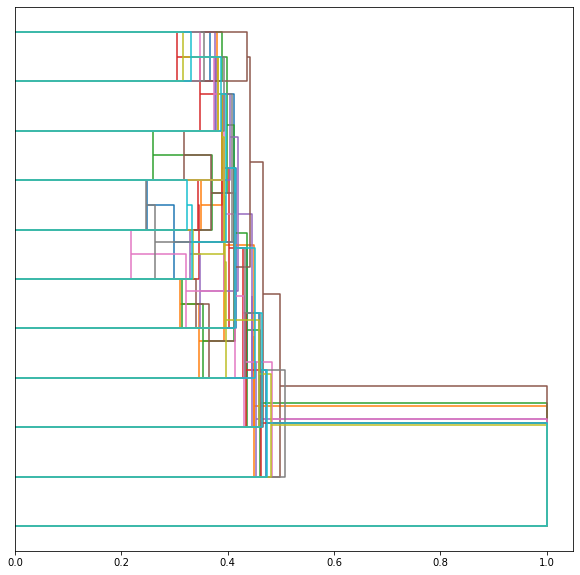

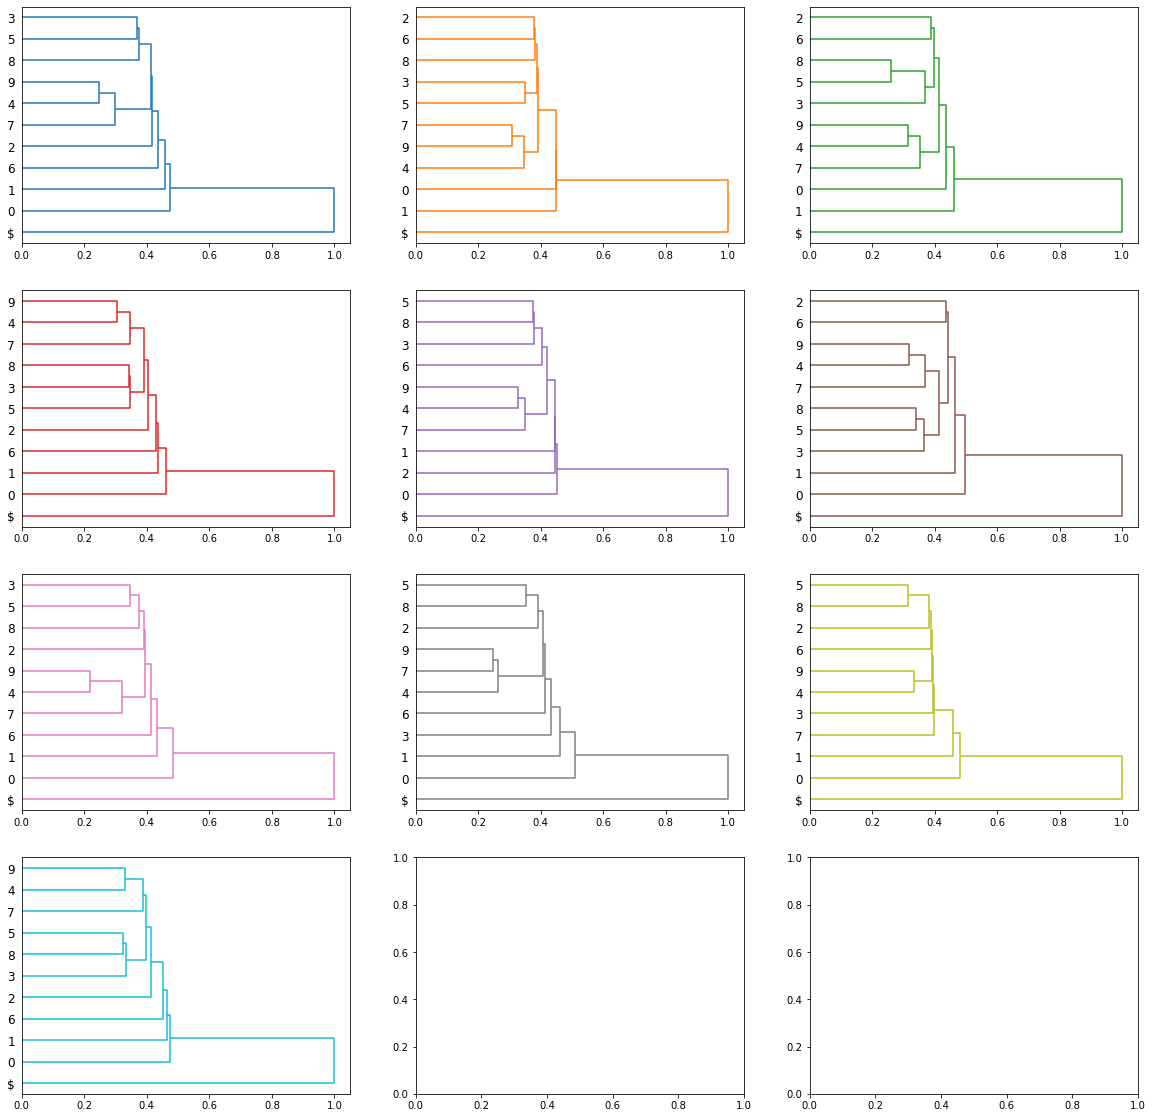

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
colors = [plt.cm.tab10(i) for i in range(10)]
for i, branch_defs in enumerate(all_branch_defs):
    linkage, cluster_id_to_leaf = branch_defs_to_linkage_matrix(branch_defs)
    scipy.cluster.hierarchy.dendrogram(
        linkage, ax=ax, orientation="right", color_threshold=0,
        link_color_func=(lambda _: plt.cm.colors.to_hex(plt.cm.tab10(i)))
    )
ax.set_yticklabels([])
plt.show()

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
for i, branch_defs in enumerate(all_branch_defs):
    linkage, cluster_id_to_leaf = branch_defs_to_linkage_matrix(branch_defs)
    row, col = i // 3, i % 3
    scipy.cluster.hierarchy.dendrogram(
        linkage, ax=ax[row][col], orientation="right", color_threshold=0,
        leaf_label_func=(lambda k: cluster_id_to_leaf[k]),
        link_color_func=(lambda _: plt.cm.colors.to_hex(plt.cm.tab10(i)))
    )
plt.show()

### Compute generative performance between different variations

In [12]:
def get_best_run(run_dir):
    best_loss, best_run = float("inf"), None
    for run_num in os.listdir(run_dir):
        if run_num == "_sources":
            continue
        metrics_path = os.path.join(run_dir, run_num, "metrics.json")
        with open(metrics_path, "r") as f:
            metrics = json.load(f)
        try:
            last_loss = metrics["train_epoch_loss"]["values"][-1]
        except KeyError:
            last_loss = float("inf")
        if last_loss < best_loss:
            best_loss, best_run = last_loss, run_num
    return best_run

In [31]:
# Import model for each trial
models = []
for i in range(num_trials):
    run_dir = os.path.join(model_base, "trial_%d" % i)
    best_run = get_best_run(run_dir)
    model_path = os.path.join(run_dir, best_run, "last_ckpt.pth")
    
    model = model_util.load_model(
        image_unet.MultitaskMNISTUNetTimeConcat,
        model_path
    ).to(DEVICE)
    models.append(model)

In [25]:
def class_time_to_branch(c, t, branch_defs):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t, branch_defs):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i, branch_defs) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

In [38]:
# For each trial/model, generate some samples
all_gen_samples = []

for i in range(num_trials):
    print("Trial %d" % i)
    gen_samples = {}
    for class_to_sample in classes:
        samples = generate.generate_continuous_branched_samples(
            models[i], diffuser, class_to_sample,
            lambda c, t: class_time_to_branch_tensor(c, t, all_branch_defs[i]),
            sampler="pc", t_limit=t_limit, num_samples=1000, verbose=True
        ).cpu().numpy()
        gen_samples[class_to_sample] = samples
    all_gen_samples.append(gen_samples)
    
    # Save the results because they take awhile to generate
    np.savez(
        os.path.join(cache_dir, "generated_digits", "trial_%d.npz" % i),
        **{str(c) : arr for c, arr in gen_samples.items()}
    )

Trial 0


100%|██████████████████████████████████████████████████████| 500/500 [00:35<00:00, 13.99it/s]


Trial 1


100%|██████████████████████████████████████████████████████| 500/500 [00:35<00:00, 14.01it/s]


Trial 2


100%|██████████████████████████████████████████████████████| 500/500 [00:35<00:00, 14.01it/s]


Trial 3


100%|██████████████████████████████████████████████████████| 500/500 [00:35<00:00, 14.02it/s]


Trial 4


100%|██████████████████████████████████████████████████████| 500/500 [00:35<00:00, 14.02it/s]


Trial 5


100%|██████████████████████████████████████████████████████| 500/500 [00:35<00:00, 14.02it/s]


Trial 6


100%|██████████████████████████████████████████████████████| 500/500 [00:35<00:00, 14.03it/s]


Trial 7


100%|██████████████████████████████████████████████████████| 500/500 [00:35<00:00, 14.02it/s]


Trial 8


100%|██████████████████████████████████████████████████████| 500/500 [00:35<00:00, 14.02it/s]


Trial 9


100%|██████████████████████████████████████████████████████| 500/500 [00:35<00:00, 14.01it/s]


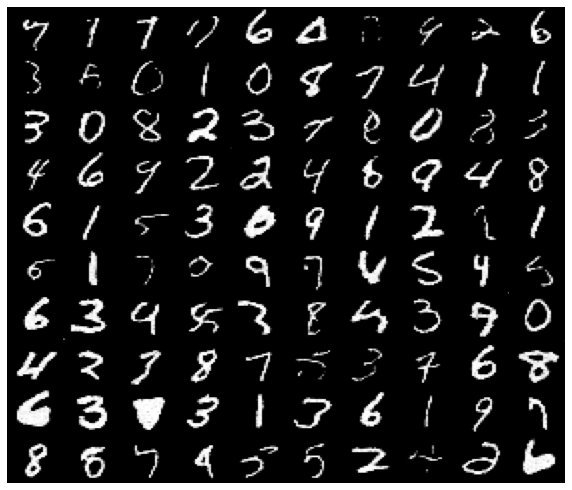

In [42]:
# Plot a few examples from each trial
num_to_plot = 100
random_samples = np.empty((num_to_plot, 1, 28, 28))
for i in range(num_to_plot):
    trial_i = np.random.choice(num_trials)
    class_i = np.random.choice(classes)
    sample_i = np.random.choice(1000)
    random_samples[i] = all_gen_samples[trial_i][class_i][sample_i]
plot_mnist_digits(random_samples, grid_size=(10, num_to_plot // 10), title=None)
plt.show()

In [43]:
# Sample true objects
true_samples = {}
for class_to_sample in classes:
    inds = np.where(dataset.targets == class_to_sample)[0]
    sample_inds = np.random.choice(inds, size=1000, replace=False)
    samples = ((dataset.data[sample_inds] / 256 * 2) - 1).cpu().numpy()[:, None]
    true_samples[class_to_sample] = samples

In [46]:
# Compute FIDs
all_fid_scores = []

for i in range(num_trials):
    print("Trial %d" % i)
    fid_scores = {}
    for class_to_sample in classes:
        fid_scores[class_to_sample] = compute_fid(
            true_samples[class_to_sample], all_gen_samples[i][class_to_sample]
        )
    all_fid_scores.append(fid_scores)

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


In [55]:
linear_fids = [
    105.5918, 49.4217, 111.4119, 87.9407, 47.4579, 72.9024, 70.4234, 56.0854, 85.4064, 58.2126
]

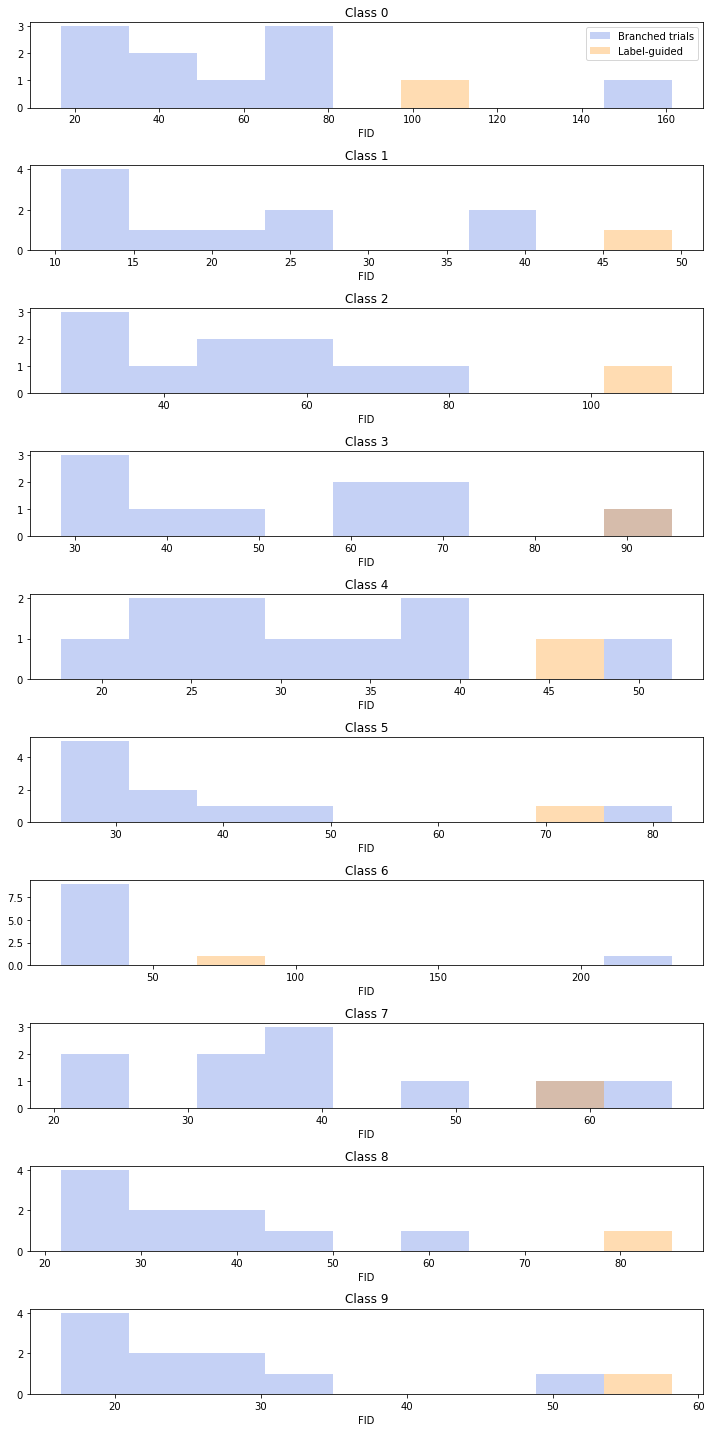

In [59]:
# Visualize FIDs between different variations
fig, ax = plt.subplots(nrows=len(classes), figsize=(10, 20))

for i, c in enumerate(classes):
    fids = [fid_scores[i] for fid_scores in all_fid_scores]
    all_vals = np.concatenate([fids, [linear_fids[i]]])
    bins = np.linspace(np.min(all_vals), np.max(all_vals), 10)
    ax[i].hist(fids, bins=bins, alpha=0.3, color="royalblue", label="Branched trials")
    ax[i].hist([linear_fids[i]], bins=bins, alpha=0.3, color="darkorange", label="Label-guided")
    ax[i].set_title("Class %d" % c)
    ax[i].set_xlabel("FID")
ax[0].legend()
fig.tight_layout()
plt.show()

### Quantify similarity between hierarchies

In [66]:
def tree_to_newick_helper(node, parent_height, newick_to_complete, leaf_id_to_name):
    """
    Converts a SciPy ClusterNode object (with branch distances) into Newick
    notation.
    Arguments:
        `node`: ClusterNode object
        `node_height`: height of the node's parent
        `newick_to_complete`: Newick string that needs to be added to the end
        `leaf_id_to_name`: dictionary mapping leaf ID to name of leaf
    Returns full Newick string.
    """
    if node.is_leaf():
        return "%s:%f%s" % (leaf_id_to_name[node.id], parent_height - node.dist, newick_to_complete)
    else:
        # Insert this internal node into newick_to_complete
        if len(newick_to_complete) > 0:
            # End with colon and branch length
            newick_to_complete = "):" + ("%f" % (parent_height - node.dist)) + newick_to_complete
        else:
            # End the string entirely
            newick_to_complete = ");"

        # Recursively tack on left node into newick_to_complete
        newick_to_complete = tree_to_newick_helper(
            node.get_left(), node.dist, newick_to_complete, leaf_id_to_name
        )
        # Recursively tack on right node into newick_to_complete
        newick_to_complete = tree_to_newick_helper(
            node.get_right(), node.dist, "," + newick_to_complete, leaf_id_to_name
        )
        # Final string just needs an open paren on the left
        return "(" + newick_to_complete
    
def linkage_to_newick(linkage, leaf_id_to_name):
    tree = scipy.cluster.hierarchy.to_tree(linkage)
    return tree_to_newick_helper(tree, tree.dist, "", leaf_id_to_name)

In [81]:
def create_random_branch_defs(node_set, t_limit):
    """
    Creates a random tree consisting of leaf nodes in the array `node_set`,
    where the total height is `t_limit`. Returns the tree as a list of
    triplets, following the "branch_defs" format:
        [
            ((1, 2, 3), 0.5, 1.0),
            ((1, 2), 0.3, 0.5),
            ((3,), 0, 0.5),
            ((1,), 0, 0.3),
            ((2,), 0, 0.2)
        ]
    """
    if len(node_set) == 1:
        return [((node_set[0],), 0, t_limit)]
    else:
        # Pick random partition of `node_set`
        node_set = np.random.permutation(node_set)
        cut_point = np.random.randint(1, len(node_set))
        node_set_1, node_set_2 = node_set[:cut_point], node_set[cut_point:]
        
        # Pick a random branch length
        length = np.random.rand() * t_limit
        
        return [(tuple(np.sort(node_set)), length, t_limit)] + \
            create_random_branch_defs(node_set_1, length) + \
            create_random_branch_defs(node_set_2, length)

In [86]:
# Write out our trees and randomly sampled trees
tree_in = os.path.join(cache_dir, "trees", "discovered_trees.in")
with open(tree_in, "w") as f:
    for i, branch_defs in enumerate(all_branch_defs):
        linkage, cluster_id_to_leaf = branch_defs_to_linkage_matrix(branch_defs, add_outgroup=False)
        f.write(linkage_to_newick(linkage, cluster_id_to_leaf) + "\n")
        
tree_in = os.path.join(cache_dir, "trees", "random_trees.in")
with open(tree_in, "w") as f:
    for _ in range(len(all_branch_defs)):
        branch_defs = create_random_branch_defs(np.arange(10), t_limit)
        linkage, cluster_id_to_leaf = branch_defs_to_linkage_matrix(branch_defs, add_outgroup=False)
        f.write(linkage_to_newick(linkage, cluster_id_to_leaf) + "\n")

In [89]:
print("WARNING: Did you need to re-run PHYLIP?")

# Import tree distances
tree_out = os.path.join(cache_dir, "trees", "discovered_trees.out")
disc_dists = np.empty((num_trials, num_trials))
with open(tree_out, "r") as f:
    for line in f:
        if not line.startswith("Trees "):
            continue
        tokens = line.strip().split()
        i, j = int(tokens[1]) - 1, int(tokens[3][:-1]) - 1
        dist = float(tokens[4])
        disc_dists[i, j] = dist
        disc_dists[j, i] = dist

tree_out = os.path.join(cache_dir, "trees", "random_trees.out")
rand_dists = np.empty((num_trials, num_trials))
with open(tree_out, "r") as f:
    for line in f:
        if not line.startswith("Trees "):
            continue
        tokens = line.strip().split()
        i, j = int(tokens[1]) - 1, int(tokens[3][:-1]) - 1
        dist = float(tokens[4])
        rand_dists[i, j] = dist
        rand_dists[j, i] = dist

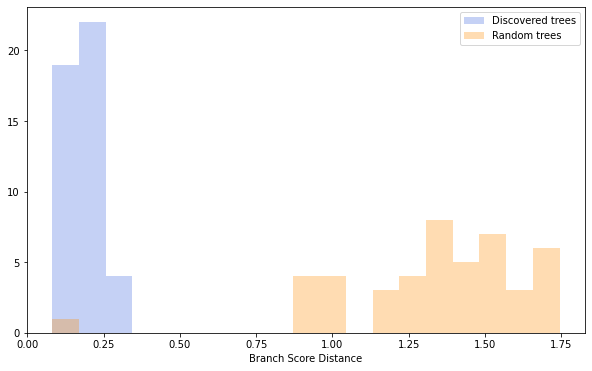

2.0679547538065143e-28


In [112]:
# Plot distances and compute significance
disc_vals = disc_dists[np.triu_indices(disc_dists.shape[0], k=1)]
rand_vals = rand_dists[np.triu_indices(rand_dists.shape[0], k=1)]
all_vals = np.concatenate([disc_vals, rand_vals])
bins = np.linspace(np.min(all_vals), np.max(all_vals), 20)
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(disc_vals, bins=bins, color="royalblue", alpha=0.3, label="Discovered trees")
ax.hist(rand_vals, bins=bins, color="darkorange", alpha=0.3, label="Random trees")
ax.set_xlabel("Branch Score Distance")
ax.legend()
plt.show()

p = scipy.stats.ttest_ind(
    disc_vals, rand_vals, equal_var=False, alternative="less"
)[1]
print(p)